Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.0s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.0s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.0s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.0s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.1s
[CV] END .clf__n_neighbors=3, clf__p=2, clf__weights=uniform; total time=   0.0s
[CV] END .clf__n_neighbors=3, clf__p=2, clf__we

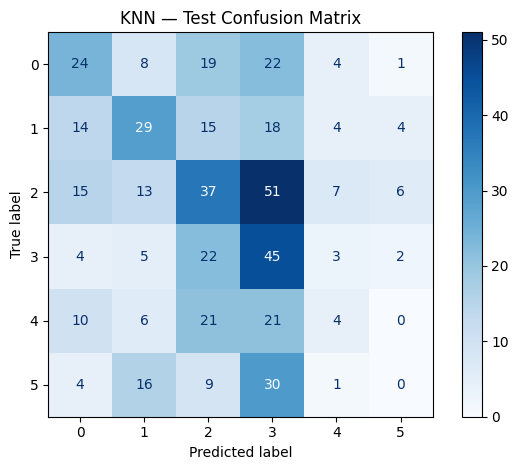

Test Set AUC (OvR): 0.6085

== Confidence Decile Table ==
      Top %  N Samples  Correct Predictions  Accuracy in Decile  \
0   Top 10%         49                   18               0.367   
1   Top 20%         98                   37               0.378   
2   Top 30%        148                   51               0.345   
3   Top 40%        197                   65               0.330   
4   Top 50%        247                   73               0.296   
5   Top 60%        296                   87               0.294   
6   Top 70%        345                  101               0.293   
7   Top 80%        395                  116               0.294   
8   Top 90%        444                  125               0.282   
9  Top 100%        494                  139               0.281   

   Avg Confidence  
0           0.622  
1           0.575  
2           0.542  
3           0.514  
4           0.491  
5           0.471  
6           0.453  
7           0.435  
8           0.419  
9   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score
)

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
train_df = pd.read_csv("../data/generated_data/train.csv")
test_df = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df['regime_today'] = train_df['regime']
test_df['regime_today'] = test_df['regime']

train_df['regime_t+3'] = train_df['regime'].shift(-3)
test_df['regime_t+3'] = test_df['regime'].shift(-3)

train_df = train_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])
test_df = test_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])

# -----------------------------
# 2. Feature / Target Split
# -----------------------------
X_train = train_df.drop(columns=['regime_t+3'])
y_train = train_df['regime_t+3'].astype(int) - 1

X_test = test_df.drop(columns=['regime_t+3'])
y_test = test_df['regime_t+3'].astype(int) - 1

# -----------------------------
# 3. Scale Features
# -----------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. KNN Optimization
# -----------------------------
pipeline_knn = Pipeline([
    ('clf', KNeighborsClassifier())
])

param_grid_knn = {
    'clf__n_neighbors': list(range(3, 21, 2)),
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_knn.fit(X_train_scaled, y_train)

print("\n== Best KNN Params ==")
print(grid_knn.best_params_)
print(f"Best CV AUC (OvR): {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_

# -----------------------------
# 5. Evaluate on Test Set
# -----------------------------
y_pred_test = best_knn.predict(X_test_scaled)
y_test_proba = best_knn.predict_proba(X_test_scaled)

print("\n== KNN — TEST Accuracy Report ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap="Blues", values_format="d")
plt.title("KNN — Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Calculate Test AUC
auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print(f"Test Set AUC (OvR): {auc_score:.4f}")

# -----------------------------
# 6. Confidence-Based Decile Analysis
# -----------------------------
confidences = y_test_proba.max(axis=1)
y_pred = np.argmax(y_test_proba, axis=1)

eval_df = pd.DataFrame({
    "true": y_test + 1,
    "pred": y_pred + 1,
    "conf": confidences
})

eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
total_correct = eval_df["correct"].sum()

for d in range(10, 110, 10):  # Deciles: 10% to 100%
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    n_samples = len(subset)
    n_correct = subset["correct"].sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    avg_conf = subset["conf"].mean() if n_samples > 0 else 0

    decile_results.append({
        "Top %": f"Top {d}%",
        "N Samples": n_samples,
        "Correct Predictions": n_correct,
        "Accuracy in Decile": round(accuracy, 3),
        "Avg Confidence": round(avg_conf, 3)
    })

decile_df = pd.DataFrame(decile_results)
print("\n== Confidence Decile Table ==")
print(decile_df)
